In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

#test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels"))



Aux function for splitting between training and testing


In [7]:
#def ParentSplitter(x):
#    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def cytoplasm(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def nucleus(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5), VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion(),ShiftScaleRotate(), ElasticTransform(),
                        OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==40]=2
        mask[mask==20]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images
path_manual_lbl = path_labels

dataset/Images/9658.bmp


<AxesSubplot:>

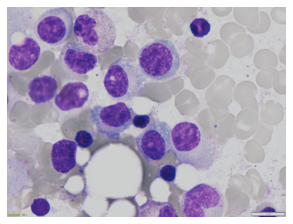

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/9658.bmp


<AxesSubplot:>

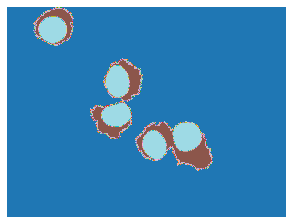

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([ 0, 20, 40], dtype=uint8)

In [19]:
size = (1000,1333)
bs = 4

In [20]:
codes

array(['Background', 'Cytoplasm', 'Nucleus'], dtype='<U10')

In [21]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [22]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
#x,mask=dls.one_batch()

# Deeplab

In [24]:
learn = get_segmentation_learner(dls=dls, number_classes=3, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50",
                                 metrics=[background,cytoplasm,nucleus,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

Recorder

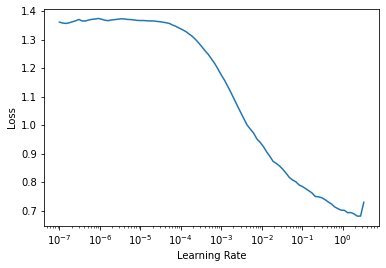

In [25]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,cytoplasm,nucleus,msa,time
0,0.824617,0.513023,0.540515,0.926628,0.919129,0.894506,01:45
1,0.420803,0.285458,0.570969,0.930549,0.931788,0.904577,01:42
2,0.266570,0.195541,0.764322,0.941857,0.938020,0.926962,01:23
3,0.222527,0.225329,0.836071,0.913434,0.912999,0.908108,01:39
4,0.217832,0.205190,0.665660,0.941343,0.935766,0.918895,01:45
5,0.199061,0.181597,0.822226,0.934555,0.924588,0.922414,02:39
6,0.191543,0.203593,0.694588,0.945886,0.932651,0.921668,02:35
7,0.186714,0.167187,0.737479,0.952603,0.942603,0.932379,03:32
8,0.180258,0.184551,0.823187,0.923435,0.926790,0.918079,03:38
9,0.176638,0.180983,0.614595,0.957215,0.947359,0.927590,03:30


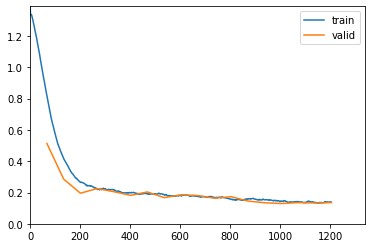

Better model found at epoch 0 with valid_loss value: 0.5130229592323303.
Better model found at epoch 1 with valid_loss value: 0.28545811772346497.
Better model found at epoch 2 with valid_loss value: 0.19554093480110168.
Better model found at epoch 5 with valid_loss value: 0.18159723281860352.
Better model found at epoch 7 with valid_loss value: 0.16718730330467224.
Better model found at epoch 10 with valid_loss value: 0.16357608139514923.
Better model found at epoch 12 with valid_loss value: 0.145534947514534.
Better model found at epoch 13 with valid_loss value: 0.1344042420387268.
Better model found at epoch 14 with valid_loss value: 0.1298748403787613.
No improvement since epoch 14: early stopping


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [26]:
fname="deeplab-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [27]:
learn.load("deeplab-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,cytoplasm,nucleus,msa,time
0,0.129432,0.131508,0.833620,0.959159,0.954422,0.948124,03:29
1,0.138872,0.131303,0.815508,0.959958,0.953780,0.946897,02:51
2,0.142089,0.130361,0.854985,0.958773,0.954123,0.949422,03:04
3,0.146332,0.130387,0.854209,0.959753,0.954131,0.949779,03:13
4,0.143239,0.130466,0.857120,0.959556,0.953820,0.949762,03:16
5,0.145438,0.133443,0.802292,0.959596,0.953793,0.945673,03:22


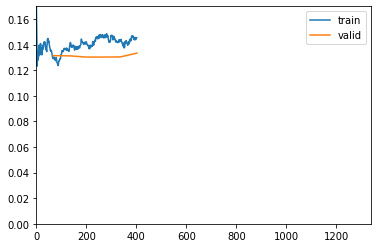

Better model found at epoch 0 with valid_loss value: 0.1315082609653473.
Better model found at epoch 1 with valid_loss value: 0.1313028186559677.
Better model found at epoch 2 with valid_loss value: 0.13036146759986877.
No improvement since epoch 2: early stopping


In [28]:
fname="deeplab-after-unfreeze"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [29]:
learn.validate()

(#5) [0.13036146759986877,0.8549854159355164,0.958772599697113,0.9541232585906982,0.9494217038154602]

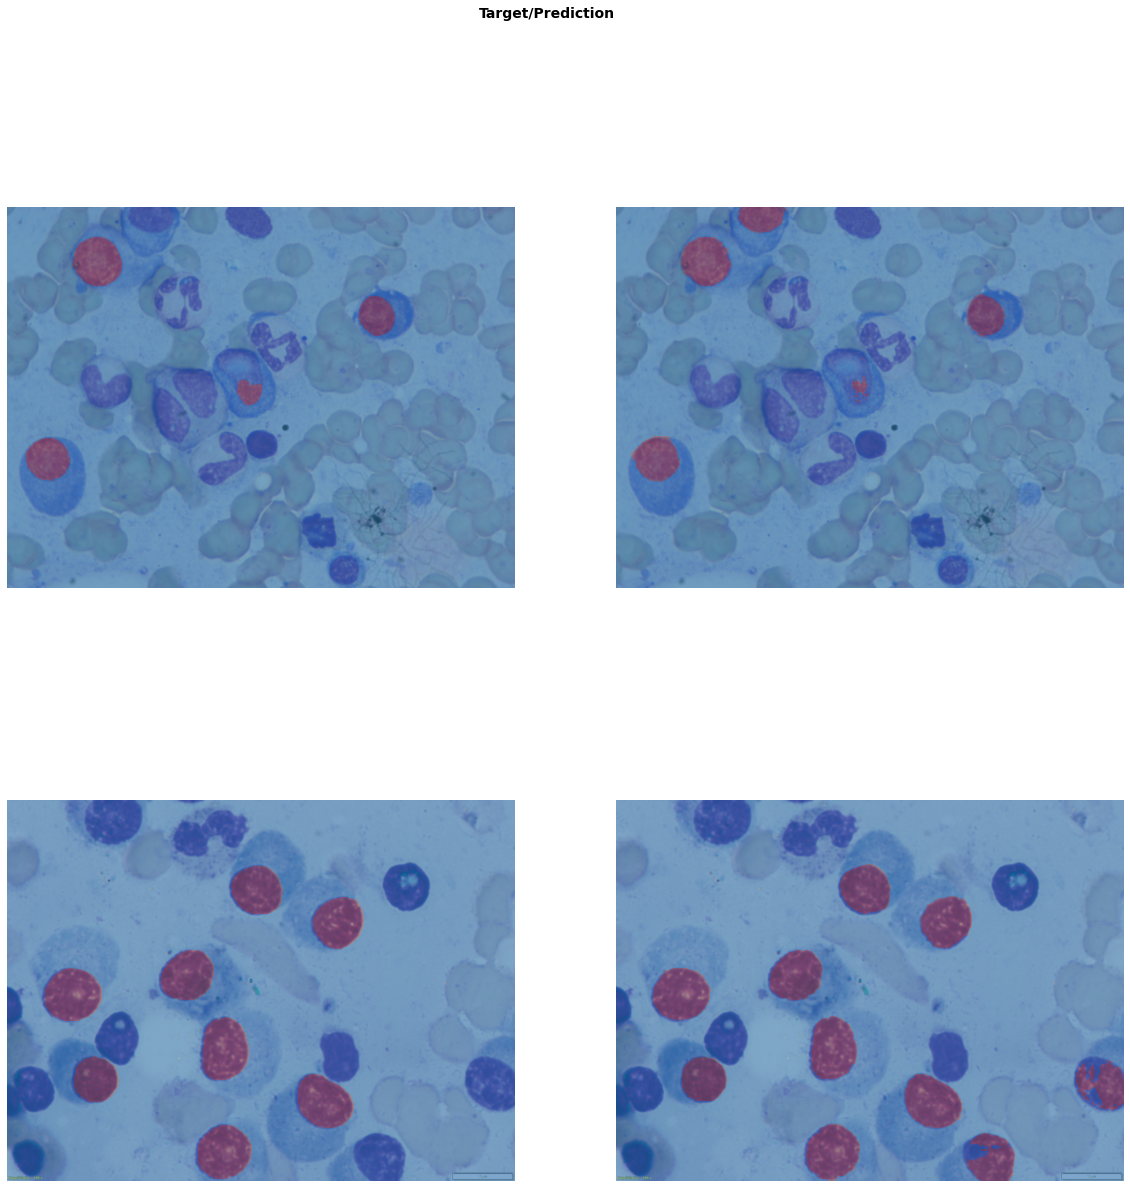

In [30]:
learn.show_results(figsize=(20,20))

In [31]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("deeplab.pth")